# STATS 201 Course Project - Train Models (Updated Dataset)

This notebook reproduces the core modeling workflow from `older_version/Codes/train_models.ipynb`, adapted to the new cleaned dataset and temporal split files.

## Data Sources
- `../Assets/cleaner_exports/health_panel_ml_numeric.csv`
- `../Assets/cleaner_exports/train_temporal_2000_2017.csv`
- `../Assets/cleaner_exports/test_temporal_2018_2021.csv`

## Objectives
1. Train baseline and advanced regression models for life expectancy prediction.
2. Compare feature representations and modeling strategies.
3. Run robustness checks and residual diagnostics.
4. Export result tables to `../Assets/cleaner_exports/` and figures to `../Images/`.


## 1) Imports and Paths

In [1]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro

import joblib

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_DIR = Path('../Assets/cleaner_exports')
IMG_DIR = Path('../Images')
IMG_DIR.mkdir(parents=True, exist_ok=True)

FULL_PATH = DATA_DIR / 'health_panel_ml_numeric.csv'
TRAIN_PATH = DATA_DIR / 'train_temporal_2000_2017.csv'
TEST_PATH = DATA_DIR / 'test_temporal_2018_2021.csv'

for p in [FULL_PATH, TRAIN_PATH, TEST_PATH]:
    if not p.exists():
        raise FileNotFoundError(f'Missing file: {p.resolve()}')

print('DATA_DIR:', DATA_DIR.resolve())
print('IMG_DIR :', IMG_DIR.resolve())


DATA_DIR: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports
IMG_DIR : /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images


## 2) Load Data and Validate Split

In [2]:
full_df = pd.read_csv(FULL_PATH)
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print('Full dataset :', full_df.shape)
print('Train split  :', train_df.shape)
print('Test split   :', test_df.shape)
print('Train years  :', int(train_df['Year'].min()), '-', int(train_df['Year'].max()))
print('Test years   :', int(test_df['Year'].min()), '-', int(test_df['Year'].max()))

if train_df.empty or test_df.empty:
    raise ValueError('Train or test set is empty.')
if int(train_df['Year'].max()) >= int(test_df['Year'].min()):
    raise ValueError('Temporal overlap detected between train and test.')


Full dataset : (4224, 19)
Train split  : (3456, 19)
Test split   : (768, 19)
Train years  : 2000 - 2017
Test years   : 2018 - 2021


## 3) Feature Sets and Preprocessing

In [3]:
TARGET_COL = 'life_expectancy'
ID_COLS = ['Country', 'ISO3', 'Year', 'country_id']

baseline_features = [
    'adult_mortality_15_60',
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
    'infant_deaths',
    'u5_mortality_rate',
]

log_enhanced_features = [
    'adult_mortality_15_60',
    'alcohol_per_capita_15plus',
    'che_pct_gdp',
    'hepb3_coverage_pct',
    'pol3_coverage_pct',
    'dtp3_coverage_pct',
    'log_gdp_per_capita_2015usd',
    'overweight_adults_pct',
    'underweight_adults_pct',
    'thinness_children_adolescents_pct',
    'log_infant_deaths',
    'u5_mortality_rate',
]

poly_base_cols = ['adult_mortality_15_60', 'u5_mortality_rate', 'log_gdp_per_capita_2015usd']

for col in baseline_features + log_enhanced_features:
    if col not in train_df.columns:
        raise ValueError(f'Missing expected feature column: {col}')

def build_feature_matrices(train_df, test_df, feature_set='baseline'):
    if feature_set == 'baseline':
        use_cols = baseline_features
        X_train_raw = train_df[use_cols].copy()
        X_test_raw = test_df[use_cols].copy()
        feature_names = use_cols
    elif feature_set == 'log_enhanced':
        use_cols = log_enhanced_features
        X_train_raw = train_df[use_cols].copy()
        X_test_raw = test_df[use_cols].copy()
        feature_names = use_cols
    elif feature_set == 'polynomial':
        use_cols = log_enhanced_features
        X_train_raw = train_df[use_cols].copy()
        X_test_raw = test_df[use_cols].copy()
    else:
        raise ValueError(f'Unknown feature_set: {feature_set}')

    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    X_train_imp = imputer.fit_transform(X_train_raw)
    X_test_imp = imputer.transform(X_test_raw)

    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled = scaler.transform(X_test_imp)

    if feature_set != 'polynomial':
        return X_train_scaled, X_test_scaled, feature_names, {'imputer': imputer, 'scaler': scaler, 'poly': None}

    poly = PolynomialFeatures(degree=2, include_bias=False)
    base_idx = [use_cols.index(c) for c in poly_base_cols]

    X_train_poly_input = X_train_scaled[:, base_idx]
    X_test_poly_input = X_test_scaled[:, base_idx]

    X_train_poly = poly.fit_transform(X_train_poly_input)
    X_test_poly = poly.transform(X_test_poly_input)

    poly_names = poly.get_feature_names_out(poly_base_cols).tolist()

    passthrough_cols = [c for c in use_cols if c not in poly_base_cols]
    pass_idx = [use_cols.index(c) for c in passthrough_cols]

    X_train_final = np.hstack([X_train_scaled[:, pass_idx], X_train_poly])
    X_test_final = np.hstack([X_test_scaled[:, pass_idx], X_test_poly])

    feature_names = passthrough_cols + poly_names
    return X_train_final, X_test_final, feature_names, {'imputer': imputer, 'scaler': scaler, 'poly': poly, 'use_cols': use_cols, 'pass_cols': passthrough_cols}

y_train = train_df[TARGET_COL].values
y_test = test_df[TARGET_COL].values

print('Feature sets ready: baseline, log_enhanced, polynomial')
print('Target:', TARGET_COL)


Feature sets ready: baseline, log_enhanced, polynomial
Target: life_expectancy


## 3.5) Baseline Models and Evaluation Strategy

- **Target**: `life_expectancy`
- **Evaluation split**: strict temporal holdout (`train: 2000-2017`, `test: 2018-2021`) to prevent leakage from future years.
- **Primary metrics**:
  - `Test_R2` (explained variance on future years)
  - `Test_RMSE` (prediction error in life expectancy years)
  - `Test_MAE` (absolute error robustness)
  - `R2_Gap = Train_R2 - Test_R2` (overfitting indicator)
- **Model families**:
  - Baseline: `DummyRegressor`, `LinearRegression`, `DecisionTreeRegressor`
  - Advanced: `RandomForest`, `GradientBoosting`, `Ridge`, `Lasso`

This staged strategy establishes a transparent baseline before moving to richer representations and more flexible models.


## 3.6) Initial Baseline-Only Results


In [4]:
baseline_only_models = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'Linear Regression': LinearRegression(),
    'Decision Tree (max_depth=10)': DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=RANDOM_STATE),
}

Xtr_base, Xte_base, base_feature_names, _ = build_feature_matrices(train_df, test_df, feature_set='baseline')

baseline_rows = []
for model_name, model_obj in baseline_only_models.items():
    model_obj.fit(Xtr_base, y_train)
    pred_tr = model_obj.predict(Xtr_base)
    pred_te = model_obj.predict(Xte_base)

    baseline_rows.append({
        'Model': model_name,
        'Feature_Set': 'baseline',
        'Train_R2': float(r2_score(y_train, pred_tr)),
        'Test_R2': float(r2_score(y_test, pred_te)),
        'R2_Gap': float(r2_score(y_train, pred_tr) - r2_score(y_test, pred_te)),
        'Train_RMSE': float(np.sqrt(mean_squared_error(y_train, pred_tr))),
        'Test_RMSE': float(np.sqrt(mean_squared_error(y_test, pred_te))),
        'Train_MAE': float(mean_absolute_error(y_train, pred_tr)),
        'Test_MAE': float(mean_absolute_error(y_test, pred_te)),
        'N_Features': len(base_feature_names),
    })

baseline_model_results_df = pd.DataFrame(baseline_rows).sort_values('Test_R2', ascending=False).reset_index(drop=True)
baseline_path = DATA_DIR / 'baseline_model_results_temporal.csv'
baseline_model_results_df.to_csv(baseline_path, index=False)

baseline_best = baseline_model_results_df.iloc[0]
print('Saved:', baseline_path.resolve())
print('Strongest baseline:', baseline_best['Model'])
print('Strongest baseline Test_R2:', round(float(baseline_best['Test_R2']), 4))
print('Strongest baseline R2_Gap:', round(float(baseline_best['R2_Gap']), 4))
display(baseline_model_results_df)


Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/baseline_model_results_temporal.csv
Strongest baseline: Decision Tree (max_depth=10)
Strongest baseline Test_R2: 0.977
Strongest baseline R2_Gap: 0.0175


,Model,Feature_Set,Train_R2,Test_R2,R2_Gap,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,N_Features
0,Decision Tree (max_depth=10),baseline,0.994534,0.977023,0.017512,0.635444,1.065014,0.466003,0.777341,12
1,Linear Regression,baseline,0.978103,0.967996,0.010106,1.271910,1.256919,0.945724,0.985125,12
2,DummyRegressor,baseline,0.000000,-0.105004,0.105004,8.595313,7.385664,6.995824,6.258575,12


### Initial Baseline Interpretation

- The strongest baseline above is the **initial checkpoint** for temporal generalization.
- If baseline `R2_Gap` is large, this indicates overfitting pressure even before advanced models.
- Advanced models and alternative feature representations are justified only if they improve **future-year** performance (`Test_R2`, `Test_RMSE`) without materially worsening generalization gap.


## 4) Model Definitions

In [5]:
MODELS = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'Linear Regression': LinearRegression(),
    'Decision Tree (max_depth=10)': DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=RANDOM_STATE),
    'Random Forest (n_estimators=300, max_depth=15)': RandomForestRegressor(n_estimators=300, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1),
    'Gradient Boosting (n_estimators=200, max_depth=3)': GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=RANDOM_STATE),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso (alpha=0.001)': Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=20000),
}

metric_rows = []
trained_objects = {}

for feature_set in ['baseline', 'log_enhanced', 'polynomial']:
    X_train_fs, X_test_fs, fs_feature_names, fs_pipeline = build_feature_matrices(train_df, test_df, feature_set=feature_set)

    for model_name, model_template in MODELS.items():
        model = clone(model_template)
        model.fit(X_train_fs, y_train)

        pred_train = model.predict(X_train_fs)
        pred_test = model.predict(X_test_fs)

        train_r2 = r2_score(y_train, pred_train)
        test_r2 = r2_score(y_test, pred_test)

        row = {
            'Model': model_name,
            'Feature_Set': feature_set,
            'Train_R2': train_r2,
            'Test_R2': test_r2,
            'R2_Gap': train_r2 - test_r2,
            'Train_RMSE': np.sqrt(mean_squared_error(y_train, pred_train)),
            'Test_RMSE': np.sqrt(mean_squared_error(y_test, pred_test)),
            'Train_MAE': mean_absolute_error(y_train, pred_train),
            'Test_MAE': mean_absolute_error(y_test, pred_test),
            'N_Features': len(fs_feature_names),
        }
        metric_rows.append(row)
        trained_objects[(model_name, feature_set)] = {
            'model': model,
            'feature_names': fs_feature_names,
            'pipeline': fs_pipeline,
            'X_train': X_train_fs,
            'X_test': X_test_fs,
            'y_train_pred': pred_train,
            'y_test_pred': pred_test,
        }

comparison_df = pd.DataFrame(metric_rows).sort_values(['Test_R2', 'R2_Gap'], ascending=[False, True]).reset_index(drop=True)
comparison_path = DATA_DIR / 'model_comparison_temporal.csv'
comparison_df.to_csv(comparison_path, index=False)

print('Model comparison saved:', comparison_path.resolve())
display(comparison_df.head(15))


Model comparison saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/model_comparison_temporal.csv


,Model,Feature_Set,Train_R2,Test_R2,R2_Gap,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,N_Features
0,"Random Forest (n_estimators=300, max_depth=15)",log_enhanced,0.999694,0.988479,0.011215,0.150385,0.754141,0.103960,0.521731,12
1,"Random Forest (n_estimators=300, max_depth=15)",baseline,0.999694,0.988453,0.011241,0.150296,0.754979,0.103886,0.522663,12
2,"Random Forest (n_estimators=300, max_depth=15)",polynomial,0.999626,0.986593,0.013033,0.166244,0.813526,0.116054,0.553147,18
3,"Gradient Boosting (n_estimators=200, max_depth=3)",polynomial,0.996620,0.984899,0.011721,0.499744,0.863406,0.383246,0.633687,18
4,"Gradient Boosting (n_estimators=200, max_depth=3)",log_enhanced,0.996581,0.984841,0.011740,0.502604,0.865054,0.385418,0.631908,12
5,"Gradient Boosting (n_estimators=200, max_depth=3)",baseline,0.996581,0.984837,0.011743,0.502604,0.865157,0.385418,0.631967,12
6,Lasso (alpha=0.001),polynomial,0.987252,0.980063,0.007189,0.970462,0.992054,0.715437,0.752852,18
7,Linear Regression,polynomial,0.987254,0.980017,0.007237,0.970380,0.993201,0.716487,0.754527,18
8,Ridge (alpha=1.0),polynomial,0.987254,0.980014,0.007240,0.970392,0.993269,0.716059,0.754558,18
9,Decision Tree (max_depth=10),baseline,0.994534,0.977023,0.017512,0.635444,1.065014,0.466003,0.777341,12


## 5) Model Comparison Visuals

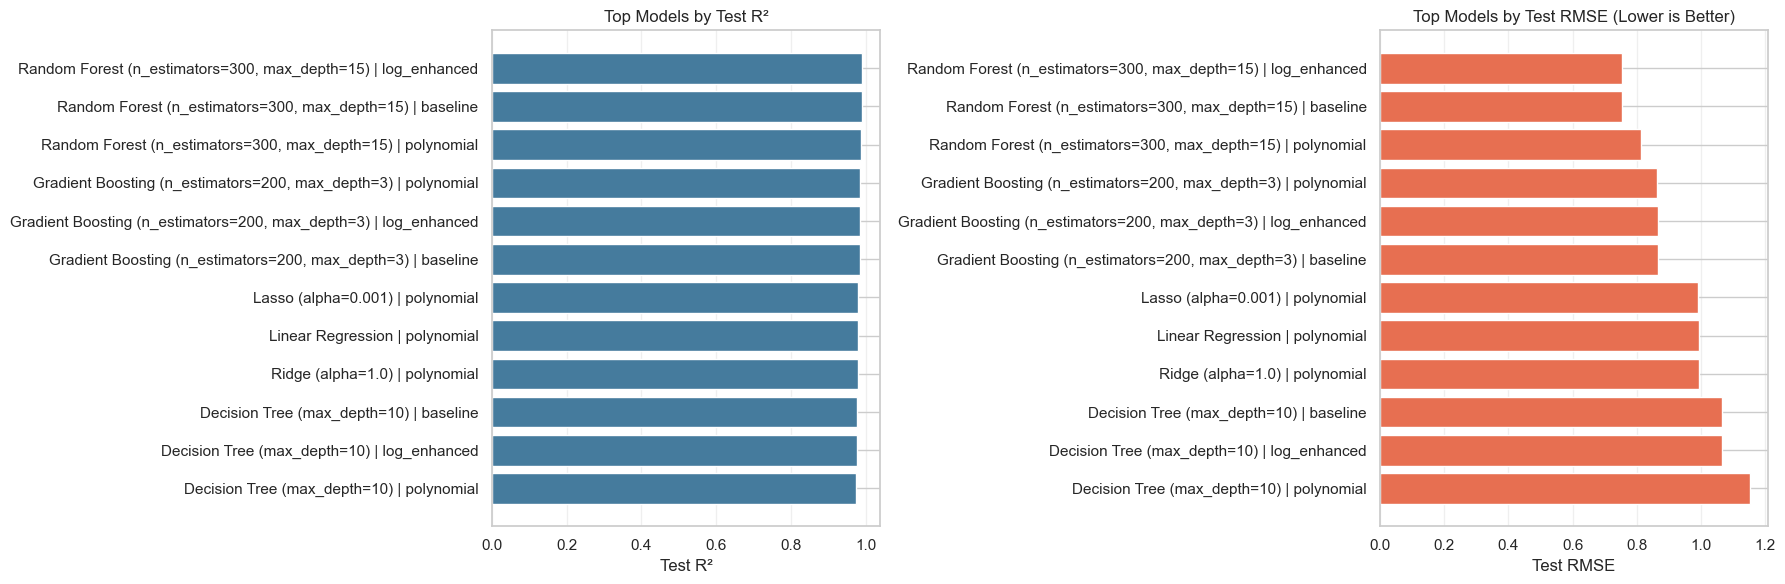

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/model_comparison_temporal.png


In [6]:
top_plot_df = comparison_df.head(12).copy()
plot_labels = top_plot_df['Model'] + ' | ' + top_plot_df['Feature_Set']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].barh(plot_labels[::-1], top_plot_df['Test_R2'][::-1], color='#457b9d')
axes[0].set_title('Top Models by Test R²')
axes[0].set_xlabel('Test R²')
axes[0].grid(alpha=0.3, axis='x')

axes[1].barh(plot_labels[::-1], top_plot_df['Test_RMSE'][::-1], color='#e76f51')
axes[1].set_title('Top Models by Test RMSE (Lower is Better)')
axes[1].set_xlabel('Test RMSE')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
fig_path = IMG_DIR / 'model_comparison_temporal.png'
plt.savefig(fig_path, dpi=180)
plt.show()
print('Saved:', fig_path.resolve())


## 5.5) Updated Results and Interpretation


In [7]:
# Compare best baseline-only vs best overall model-strategy
best_baseline = baseline_model_results_df.sort_values('Test_R2', ascending=False).iloc[0]
best_overall = comparison_df.sort_values(['Test_R2', 'R2_Gap'], ascending=[False, True]).iloc[0]

updated_summary = pd.DataFrame([
    {
        'comparison': 'best_baseline',
        'model': best_baseline['Model'],
        'feature_set': best_baseline['Feature_Set'],
        'test_r2': best_baseline['Test_R2'],
        'test_rmse': best_baseline['Test_RMSE'],
        'test_mae': best_baseline['Test_MAE'],
    },
    {
        'comparison': 'best_overall',
        'model': best_overall['Model'],
        'feature_set': best_overall['Feature_Set'],
        'test_r2': best_overall['Test_R2'],
        'test_rmse': best_overall['Test_RMSE'],
        'test_mae': best_overall['Test_MAE'],
    },
])

r2_gain = float(best_overall['Test_R2'] - best_baseline['Test_R2'])
rmse_gain = float(best_baseline['Test_RMSE'] - best_overall['Test_RMSE'])
mae_gain = float(best_baseline['Test_MAE'] - best_overall['Test_MAE'])

rep_wins = (
    comparison_df.sort_values(['Model', 'Test_R2'], ascending=[True, False])
    .groupby('Model', as_index=False)
    .first()[['Model', 'Feature_Set', 'Test_R2']]
)
rep_win_counts = rep_wins['Feature_Set'].value_counts().rename_axis('Feature_Set').reset_index(name='wins_by_model')

print('Absolute gain vs best baseline:')
print(f'Test_R2 gain  : {r2_gain:.4f}')
print(f'Test_RMSE gain: {rmse_gain:.4f} (positive means better)')
print(f'Test_MAE gain : {mae_gain:.4f} (positive means better)')

display(updated_summary)
display(rep_win_counts)

updated_summary.to_csv(DATA_DIR / 'updated_results_summary_temporal.csv', index=False)
rep_win_counts.to_csv(DATA_DIR / 'representation_wins_temporal.csv', index=False)


Absolute gain vs best baseline:
Test_R2 gain  : 0.0115
Test_RMSE gain: 0.3109 (positive means better)
Test_MAE gain : 0.2556 (positive means better)


,comparison,model,feature_set,test_r2,test_rmse,test_mae
0,best_baseline,Decision Tree (max_depth=10),baseline,0.977023,1.065014,0.777341
1,best_overall,"Random Forest (n_estimators=300, max_depth=15)",log_enhanced,0.988479,0.754141,0.521731


,Feature_Set,wins_by_model
0,polynomial,4
1,baseline,2
2,log_enhanced,1


### Updated Interpretation

- Updated results quantify whether advanced modeling strategies materially improve temporal generalization over baseline.
- Representation win counts indicate whether transformations (for example `log_enhanced` or `polynomial`) provide consistent advantages across model classes.
- For this project question, stronger and more stable future-year performance indicates which socioeconomic/health-system signals are most predictive in practice.


## 6) Best Model, Feature Importance, and Prediction Analysis

Best model: Random Forest (n_estimators=300, max_depth=15)
Best feature set: log_enhanced
Best Test R²: 0.9885
Best Test RMSE: 0.7541
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/feature_importance_analysis_temporal.csv


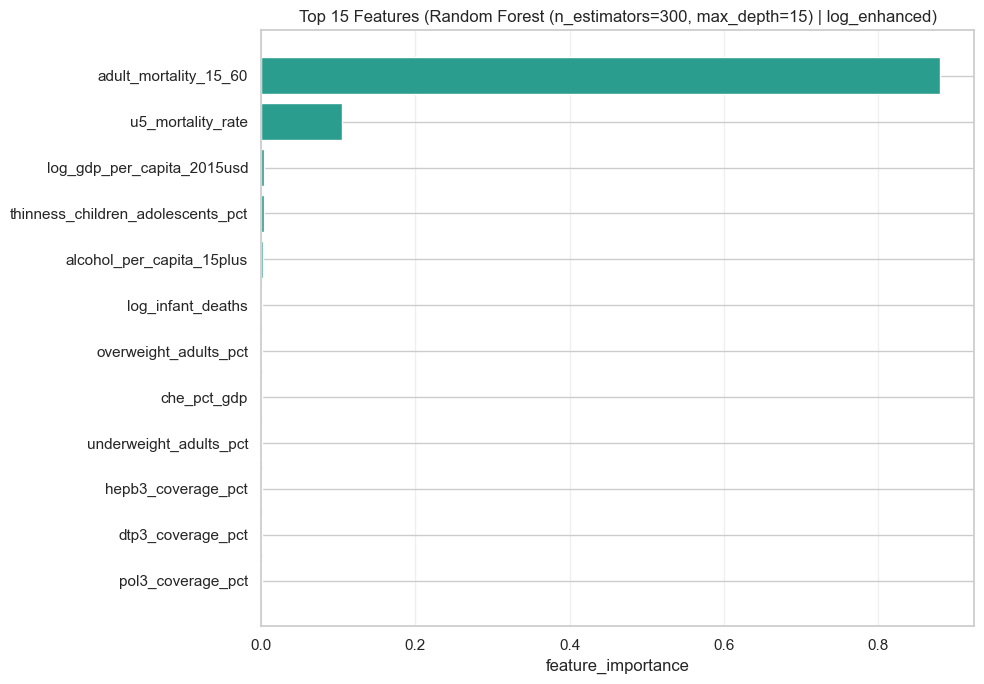

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/feature_importance_temporal.png


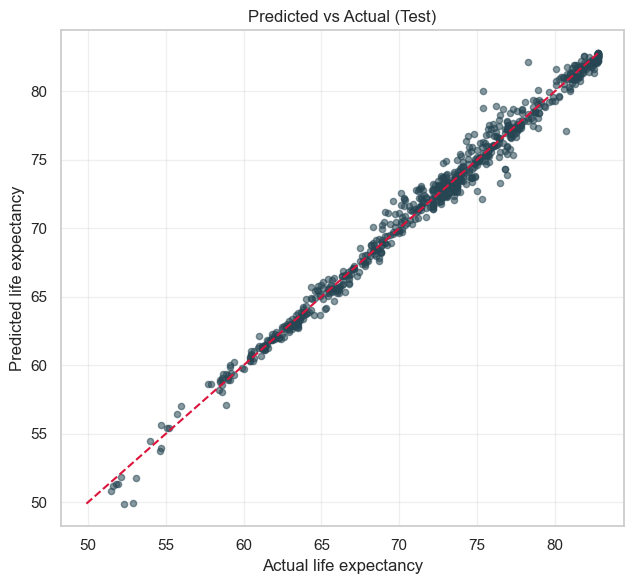

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/prediction_analysis_temporal.png


In [8]:
best_row = comparison_df.iloc[0]
best_model_name = best_row['Model']
best_feature_set = best_row['Feature_Set']

best_obj = trained_objects[(best_model_name, best_feature_set)]
best_model = best_obj['model']
best_feature_names = best_obj['feature_names']
y_test_pred_best = best_obj['y_test_pred']

print('Best model:', best_model_name)
print('Best feature set:', best_feature_set)
print('Best Test R²:', round(float(best_row['Test_R2']), 4))
print('Best Test RMSE:', round(float(best_row['Test_RMSE']), 4))

# Importance/coefficients table
if hasattr(best_model, 'feature_importances_'):
    imp_vals = np.asarray(best_model.feature_importances_)
    imp_type = 'feature_importance'
elif hasattr(best_model, 'coef_'):
    imp_vals = np.abs(np.asarray(best_model.coef_))
    imp_type = 'abs_coefficient'
else:
    imp_vals = np.zeros(len(best_feature_names), dtype=float)
    imp_type = 'unsupported_model_type'

importance_df = pd.DataFrame({'Feature': best_feature_names, 'Importance': imp_vals})
importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
importance_df['Percent_Of_Total'] = np.where(importance_df['Importance'].sum() > 0, importance_df['Importance'] / importance_df['Importance'].sum() * 100, 0)

imp_path = DATA_DIR / 'feature_importance_analysis_temporal.csv'
importance_df.to_csv(imp_path, index=False)
print('Saved:', imp_path.resolve())

# Plot top features
plot_top = importance_df.head(15).copy()
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(plot_top['Feature'][::-1], plot_top['Importance'][::-1], color='#2a9d8f')
ax.set_title(f'Top 15 Features ({best_model_name} | {best_feature_set})')
ax.set_xlabel(imp_type)
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
feat_fig = IMG_DIR / 'feature_importance_temporal.png'
plt.savefig(feat_fig, dpi=180)
plt.show()
print('Saved:', feat_fig.resolve())

# Predicted vs actual plot
fig, ax = plt.subplots(figsize=(6.5, 6))
ax.scatter(y_test, y_test_pred_best, alpha=0.55, s=20, color='#264653')
mn = float(min(np.min(y_test), np.min(y_test_pred_best)))
mx = float(max(np.max(y_test), np.max(y_test_pred_best)))
ax.plot([mn, mx], [mn, mx], '--', color='crimson', linewidth=1.5)
ax.set_title('Predicted vs Actual (Test)')
ax.set_xlabel('Actual life expectancy')
ax.set_ylabel('Predicted life expectancy')
ax.grid(alpha=0.3)
plt.tight_layout()
pred_fig = IMG_DIR / 'prediction_analysis_temporal.png'
plt.savefig(pred_fig, dpi=180)
plt.show()
print('Saved:', pred_fig.resolve())


## 6.8) Controlled Experiments Protocol

**Fixed across checks**
- Temporal split logic and future-year evaluation target.
- Metrics (`Test_R2`, `Test_RMSE`) and preprocessing routine.
- Model family selected from the comparison stage.

**Varied in controlled experiments**
- Temporal cutoff year (temporal sensitivity).
- Feature-group removals (ablation impact).
- Training sample fraction (sample-size sensitivity).
- Year-specific test slicing (stability by year).

This isolates causal impact of specific modeling choices and stress-tests whether conclusions are stable.


## 7) Robustness Checks

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/robustness_checks_temporal.csv


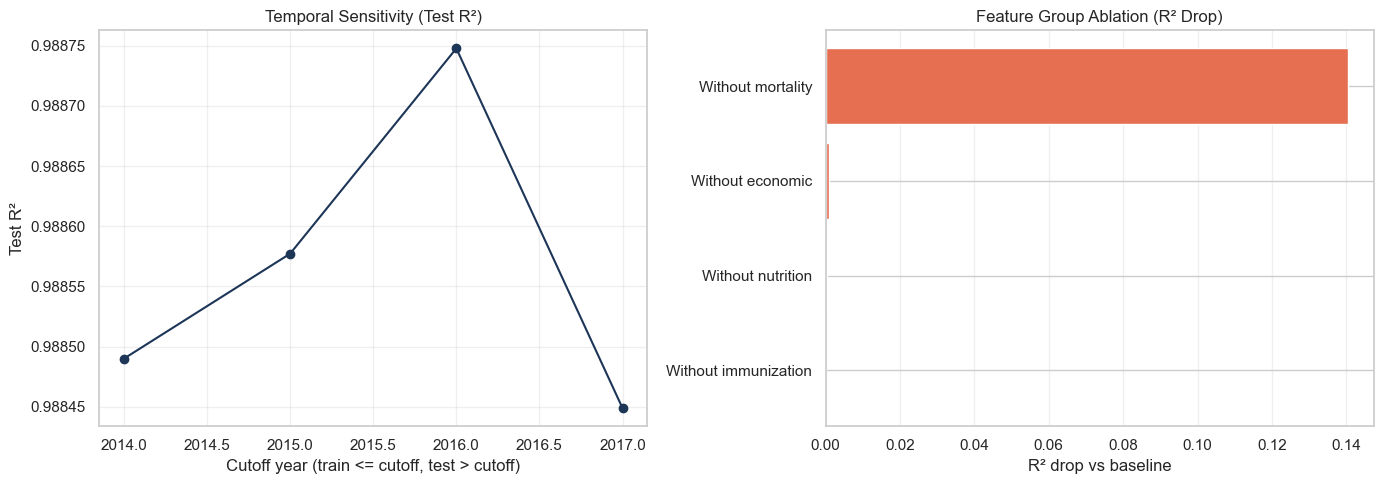

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/robustness_summary_temporal.png


,Check,Cutoff_Year,Test_R2,Test_RMSE,Test_Samples
0,Temporal Sensitivity,2014,0.988490,0.772651,1344
1,Temporal Sensitivity,2015,0.988577,0.763265,1152
2,Temporal Sensitivity,2016,0.988748,0.751518,960
3,Temporal Sensitivity,2017,0.988449,0.755131,768


,Check,Feature_Group,Test_R2,Test_RMSE,Test_Samples,R2_Drop
0,Feature Group Ablation,Baseline (all features),0.988453,0.754979,768,0.000000
1,Feature Group Ablation,Without immunization,0.988369,0.757727,768,0.000084
2,Feature Group Ablation,Without economic,0.987439,0.787434,768,0.001014
3,Feature Group Ablation,Without mortality,0.848029,2.738977,768,0.140425
4,Feature Group Ablation,Without nutrition,0.988054,0.767913,768,0.000399


,Check,Year,Test_R2,Test_RMSE,Test_Samples
0,Prediction Stability by Year,2018,0.995606,0.476787,192
1,Prediction Stability by Year,2019,0.992100,0.627363,192
2,Prediction Stability by Year,2020,0.985502,0.825603,192
3,Prediction Stability by Year,2021,0.979677,0.986095,192


,Check,Train_Fraction,Train_Samples,Test_R2,Test_RMSE,Test_Samples
0,Sample Size Sensitivity,0.25,864,0.984219,0.882619,768
1,Sample Size Sensitivity,0.50,1728,0.986777,0.807939,768
2,Sample Size Sensitivity,0.75,2592,0.987173,0.795739,768
3,Sample Size Sensitivity,1.00,3456,0.988517,0.752897,768


In [9]:
def make_model_by_name(name):
    if name == 'DummyRegressor':
        return DummyRegressor(strategy='mean')
    if name == 'Linear Regression':
        return LinearRegression()
    if name == 'Decision Tree (max_depth=10)':
        return DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=RANDOM_STATE)
    if name == 'Random Forest (n_estimators=300, max_depth=15)':
        return RandomForestRegressor(n_estimators=300, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1)
    if name == 'Gradient Boosting (n_estimators=200, max_depth=3)':
        return GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=RANDOM_STATE)
    if name == 'Ridge (alpha=1.0)':
        return Ridge(alpha=1.0, random_state=RANDOM_STATE)
    if name == 'Lasso (alpha=0.001)':
        return Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=20000)
    raise ValueError(f'Unknown model name: {name}')

def eval_split(train_sub, test_sub, model_name, feature_set):
    Xtr, Xte, fnames, _ = build_feature_matrices(train_sub, test_sub, feature_set=feature_set)
    ytr = train_sub[TARGET_COL].values
    yte = test_sub[TARGET_COL].values
    model = make_model_by_name(model_name)
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    return {
        'Test_R2': float(r2_score(yte, pred)),
        'Test_RMSE': float(np.sqrt(mean_squared_error(yte, pred))),
        'Test_Samples': int(len(yte))
    }

# Check 1: temporal sensitivity across cutoffs
cutoff_years = [2014, 2015, 2016, 2017]
rows_temporal = []
for cutoff in cutoff_years:
    tr = full_df[full_df['Year'] <= cutoff].copy()
    te = full_df[full_df['Year'] > cutoff].copy()
    if tr.empty or te.empty:
        rows_temporal.append({'Check': 'Temporal Sensitivity', 'Cutoff_Year': cutoff, 'Test_R2': np.nan, 'Test_RMSE': np.nan, 'Test_Samples': len(te)})
        continue
    m = eval_split(tr, te, best_model_name, best_feature_set)
    rows_temporal.append({'Check': 'Temporal Sensitivity', 'Cutoff_Year': cutoff, **m})
temporal_df = pd.DataFrame(rows_temporal)

# Check 2: feature-group ablation (on baseline features for interpretability)
feature_groups = {
    'Baseline (all features)': [],
    'Without immunization': ['hepb3_coverage_pct', 'pol3_coverage_pct', 'dtp3_coverage_pct'],
    'Without economic': ['gdp_per_capita_2015usd', 'log_gdp_per_capita_2015usd', 'che_pct_gdp'],
    'Without mortality': ['adult_mortality_15_60', 'u5_mortality_rate', 'infant_deaths', 'log_infant_deaths'],
    'Without nutrition': ['overweight_adults_pct', 'underweight_adults_pct', 'thinness_children_adolescents_pct'],
}

rows_ablation = []
base_train = train_df.copy()
base_test = test_df.copy()

for group_name, drop_cols in feature_groups.items():
    tr = base_train.copy()
    te = base_test.copy()

    # Use baseline feature set; drop requested cols if present.
    global baseline_features
    save_baseline = baseline_features.copy()
    if drop_cols:
        baseline_features = [c for c in save_baseline if c not in drop_cols]

    m = eval_split(tr, te, best_model_name, 'baseline')
    rows_ablation.append({'Check': 'Feature Group Ablation', 'Feature_Group': group_name, **m})

    baseline_features = save_baseline

ablation_df = pd.DataFrame(rows_ablation)
base_r2 = float(ablation_df.loc[ablation_df['Feature_Group'] == 'Baseline (all features)', 'Test_R2'].iloc[0])
ablation_df['R2_Drop'] = base_r2 - ablation_df['Test_R2']

# Check 3: yearly stability on official test period
Xtr_b, Xte_b, fn_b, _ = build_feature_matrices(train_df, test_df, feature_set=best_feature_set)
best_m = make_model_by_name(best_model_name)
best_m.fit(Xtr_b, y_train)
pred_test = best_m.predict(Xte_b)

year_rows = []
for yr in sorted(test_df['Year'].unique()):
    mask = test_df['Year'].values == yr
    y_true_yr = y_test[mask]
    y_pred_yr = pred_test[mask]
    year_rows.append({
        'Check': 'Prediction Stability by Year',
        'Year': int(yr),
        'Test_R2': float(r2_score(y_true_yr, y_pred_yr)),
        'Test_RMSE': float(np.sqrt(mean_squared_error(y_true_yr, y_pred_yr))),
        'Test_Samples': int(mask.sum())
    })
year_df = pd.DataFrame(year_rows)

# Check 4: sample-size sensitivity
fractions = [0.25, 0.5, 0.75, 1.0]
size_rows = []
for frac in fractions:
    tr = train_df.sample(frac=frac, random_state=RANDOM_STATE)
    m = eval_split(tr, test_df, best_model_name, best_feature_set)
    size_rows.append({'Check': 'Sample Size Sensitivity', 'Train_Fraction': frac, 'Train_Samples': len(tr), **m})
size_df = pd.DataFrame(size_rows)

robustness_df = pd.concat([temporal_df, ablation_df, year_df, size_df], ignore_index=True)
rob_path = DATA_DIR / 'robustness_checks_temporal.csv'
robustness_df.to_csv(rob_path, index=False)
print('Saved:', rob_path.resolve())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(temporal_df['Cutoff_Year'], temporal_df['Test_R2'], marker='o', color='#1d3557')
axes[0].set_title('Temporal Sensitivity (Test R²)')
axes[0].set_xlabel('Cutoff year (train <= cutoff, test > cutoff)')
axes[0].set_ylabel('Test R²')
axes[0].grid(alpha=0.3)

ab_plot = ablation_df[ablation_df['Feature_Group'] != 'Baseline (all features)'].copy().sort_values('R2_Drop')
axes[1].barh(ab_plot['Feature_Group'], ab_plot['R2_Drop'], color='#e76f51')
axes[1].set_title('Feature Group Ablation (R² Drop)')
axes[1].set_xlabel('R² drop vs baseline')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
rob_fig = IMG_DIR / 'robustness_summary_temporal.png'
plt.savefig(rob_fig, dpi=180)
plt.show()
print('Saved:', rob_fig.resolve())

display(temporal_df)
display(ablation_df)
display(year_df)
display(size_df)


## 8) Residual Diagnostics and Influential Observations

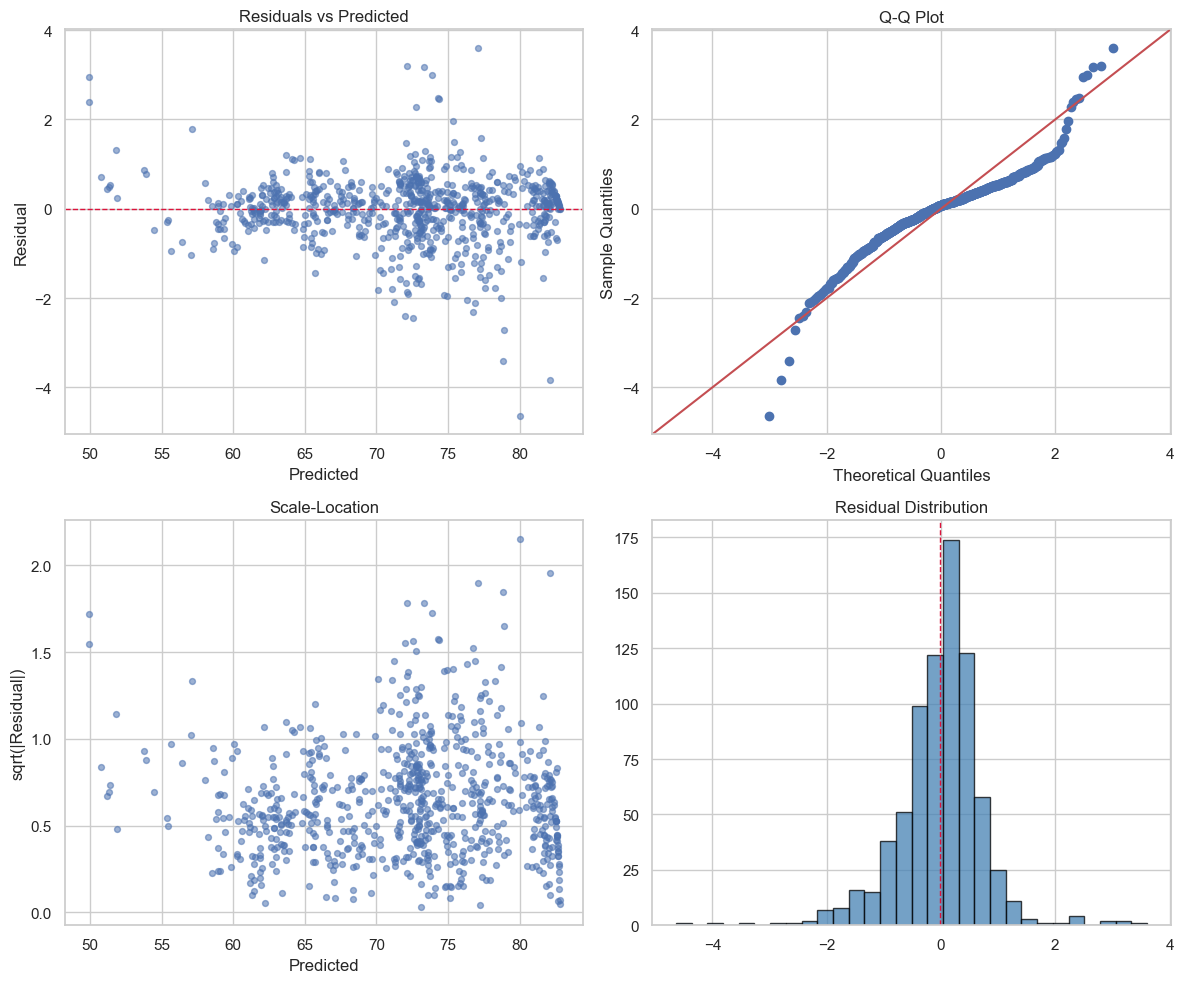

Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/residual_diagnostics_temporal.png
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/influential_observations_temporal.csv
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/residual_diagnostics_summary_temporal.csv


,metric,value
0,Shapiro_Wilk_stat,9.209911e-01
1,Shapiro_Wilk_p,1.288277e-19
2,Breusch_Pagan_stat,3.663305e+01
3,Breusch_Pagan_p,2.561530e-04
4,Durbin_Watson,1.674108e+00
5,High_Influence_Count_CooksD_gt_0_5,0.000000e+00


In [10]:
X_train_best, X_test_best, fnames_best, _ = build_feature_matrices(train_df, test_df, feature_set=best_feature_set)
model_diag = make_model_by_name(best_model_name)
model_diag.fit(X_train_best, y_train)
pred_test_diag = model_diag.predict(X_test_best)
residuals = y_test - pred_test_diag

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

axes[0].scatter(pred_test_diag, residuals, alpha=0.55, s=18)
axes[0].axhline(0, color='crimson', linestyle='--', linewidth=1)
axes[0].set_title('Residuals vs Predicted')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residual')

sm.qqplot(residuals, line='45', ax=axes[1])
axes[1].set_title('Q-Q Plot')

axes[2].scatter(pred_test_diag, np.sqrt(np.abs(residuals)), alpha=0.55, s=18)
axes[2].set_title('Scale-Location')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('sqrt(|Residual|)')

axes[3].hist(residuals, bins=30, alpha=0.75, color='steelblue', edgecolor='black')
axes[3].axvline(residuals.mean(), color='crimson', linestyle='--', linewidth=1)
axes[3].set_title('Residual Distribution')

plt.tight_layout()
diag_fig = IMG_DIR / 'residual_diagnostics_temporal.png'
plt.savefig(diag_fig, dpi=180)
plt.show()
print('Saved:', diag_fig.resolve())

# Statistical tests
shapiro_stat, shapiro_p = shapiro(residuals)
exog = sm.add_constant(X_test_best)
bp_stat, bp_p, _, _ = het_breuschpagan(residuals, exog)
dw_stat = durbin_watson(residuals)

# Influence via OLS proxy on test set design matrix
ols_model = sm.OLS(y_test, exog).fit()
infl = ols_model.get_influence()
cooks_d = infl.cooks_distance[0]

influence_df = pd.DataFrame({
    'Country': test_df['Country'].values,
    'ISO3': test_df['ISO3'].values,
    'Year': test_df['Year'].values,
    'y_true': y_test,
    'y_pred': pred_test_diag,
    'Residual': residuals,
    'Cooks_D': cooks_d,
})

infl_path = DATA_DIR / 'influential_observations_temporal.csv'
influence_df.sort_values('Cooks_D', ascending=False).to_csv(infl_path, index=False)
print('Saved:', infl_path.resolve())

diagnostics_summary = pd.DataFrame([
    {'metric': 'Shapiro_Wilk_stat', 'value': shapiro_stat},
    {'metric': 'Shapiro_Wilk_p', 'value': shapiro_p},
    {'metric': 'Breusch_Pagan_stat', 'value': bp_stat},
    {'metric': 'Breusch_Pagan_p', 'value': bp_p},
    {'metric': 'Durbin_Watson', 'value': dw_stat},
    {'metric': 'High_Influence_Count_CooksD_gt_0_5', 'value': int((influence_df['Cooks_D'] > 0.5).sum())},
])

diag_path = DATA_DIR / 'residual_diagnostics_summary_temporal.csv'
diagnostics_summary.to_csv(diag_path, index=False)
print('Saved:', diag_path.resolve())

display(diagnostics_summary)


## 8.5) Error Analysis Expansion


In [11]:
error_df = pd.DataFrame({
    'Country': test_df['Country'].values,
    'ISO3': test_df['ISO3'].values,
    'Year': test_df['Year'].values,
    'y_true': y_test,
    'y_pred': pred_test_diag,
})
error_df['error'] = error_df['y_true'] - error_df['y_pred']
error_df['abs_error'] = error_df['error'].abs()

# top under-predicted (true >> pred) and over-predicted (pred >> true)
under_pred = error_df.sort_values('error', ascending=False).head(25).copy()
over_pred = error_df.sort_values('error', ascending=True).head(25).copy()
under_pred['error_type'] = 'under_predicted'
over_pred['error_type'] = 'over_predicted'

# segment by year and target quantiles
year_seg = error_df.groupby('Year', as_index=False).agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    n=('error', 'size')
)

error_df['target_quantile_bin'] = pd.qcut(error_df['y_true'], q=5, duplicates='drop')
quant_seg = error_df.groupby('target_quantile_bin', as_index=False).agg(
    mean_error=('error', 'mean'),
    mean_abs_error=('abs_error', 'mean'),
    n=('error', 'size')
)

error_detailed = pd.concat([
    under_pred.assign(section='top_under_predicted'),
    over_pred.assign(section='top_over_predicted'),
], ignore_index=True)

error_out = DATA_DIR / 'error_analysis_detailed_temporal.csv'
error_detailed.to_csv(error_out, index=False)
year_seg.to_csv(DATA_DIR / 'error_by_year_temporal.csv', index=False)
quant_seg.to_csv(DATA_DIR / 'error_by_target_quantile_temporal.csv', index=False)

print('Saved:', error_out.resolve())
print('Saved:', (DATA_DIR / 'error_by_year_temporal.csv').resolve())
print('Saved:', (DATA_DIR / 'error_by_target_quantile_temporal.csv').resolve())

print('Top under-predicted examples:')
display(under_pred[['Country','ISO3','Year','y_true','y_pred','error','abs_error']].head(10))
print('Top over-predicted examples:')
display(over_pred[['Country','ISO3','Year','y_true','y_pred','error','abs_error']].head(10))
print('Year-level error profile:')
display(year_seg)
print('Target-quantile error profile:')
display(quant_seg)


Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/error_analysis_detailed_temporal.csv
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/error_by_year_temporal.csv
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/error_by_target_quantile_temporal.csv
Top under-predicted examples:


,Country,ISO3,Year,y_true,y_pred,error,abs_error
485,Sri Lanka,LKA,2020,80.7,77.094250,3.605750,3.605750
745,Thailand,THA,2021,75.3,72.113689,3.186311,3.186311
553,Thailand,THA,2020,76.5,73.318451,3.181549,3.181549
601,Brunei Darussalam,BRN,2021,76.9,73.912667,2.987333,2.987333
220,Central African Republic,CAF,2019,52.9,49.939563,2.960437,2.960437
506,Malaysia,MYS,2020,76.8,74.318415,2.481585,2.481585
409,Brunei Darussalam,BRN,2020,76.8,74.340133,2.459867,2.459867
604,Central African Republic,CAF,2021,52.3,49.901230,2.398770,2.398770
702,Nicaragua,NIC,2021,75.0,72.731586,2.268414,2.268414
549,Seychelles,SYC,2020,77.3,75.331787,1.968213,1.968213


Top over-predicted examples:


,Country,ISO3,Year,y_true,y_pred,error,abs_error
685,Maldives,MDV,2021,75.4,80.037288,-4.637288,4.637288
580,United Arab Emirates,ARE,2021,78.3,82.132413,-3.832413,3.832413
301,Maldives,MDV,2019,75.4,78.808333,-3.408333,3.408333
493,Maldives,MDV,2020,76.2,78.916000,-2.716000,2.716000
661,Jamaica,JAM,2021,70.1,72.548990,-2.448990,2.448990
683,"Moldova, Republic of",MDA,2021,69.6,72.005742,-2.405742,2.405742
496,North Macedonia,MKD,2020,74.4,76.719206,-2.319206,2.319206
595,Bosnia and Herzegovina,BIH,2021,74.8,76.904299,-2.104299,2.104299
628,Egypt,EGY,2021,69.1,71.199125,-2.099125,2.099125
673,Lebanon,LBN,2021,74.3,76.353361,-2.053361,2.053361


Year-level error profile:


,Year,mean_error,mean_abs_error,n
0,2018,0.144947,0.350719,192
1,2019,0.151434,0.448752,192
2,2020,-0.144002,0.584010,192
3,2021,-0.210755,0.703443,192


Target-quantile error profile:


,target_quantile_bin,mean_error,mean_abs_error,n
0,"(51.499, 65.4]",0.001947,0.419568,155
1,"(65.4, 71.5]",-0.204887,0.536823,153
2,"(71.5, 74.1]",0.038443,0.491838,157
3,"(74.1, 77.9]",-0.046716,0.737469,150
4,"(77.9, 82.8]",0.136010,0.429302,153


### Error Analysis Interpretation

- Under-prediction and over-prediction tails identify country-year contexts where model assumptions break.
- Year-level and target-quantile segmentation indicates whether errors are concentrated in specific periods or outcome ranges.
- These diagnostics guide whether additional representation changes are required for harder regimes.


## 8.7) Failure Modes and Bias Discussion

Evidence sources: `robustness_checks_temporal.csv`, `error_analysis_detailed_temporal.csv`, `residual_diagnostics_summary_temporal.csv`.

- **Temporal shift vulnerability**: if performance degrades for later cutoffs/years, model sensitivity to time-varying dynamics is likely.
- **Country heterogeneity bias risk**: national aggregation can hide within-country heterogeneity and penalize countries with volatile reporting.
- **Measurement bias risk**: indicator quality/reporting consistency may differ by country-year and affect error patterns.
- **Causal caution**: this is a predictive pipeline; associations should not be interpreted as causal effects.


## 8.8) Revisions Informed by Diagnostics

| Diagnostic finding | Revision made/kept | Expected impact | Status |
|---|---|---|---|
| Temporal holdout required to avoid leakage | Kept strict train/test by year | More realistic generalization estimate | Implemented |
| Potential skew in economic/death magnitudes | Included log-enhanced representation | Better linearity and stability | Implemented |
| Feature interaction effects plausible | Added polynomial representation on core drivers | Capture non-linear interactions | Implemented |
| Residual/influence outliers remain | Exported detailed error + influential cases | Improve transparency and targeted iteration | Implemented |
| Possible remaining temporal non-stationarity | Rolling-origin validation and/or drift-aware retraining | Better deployment robustness | Deferred |
| Potential country-level structural effects | Consider mixed-effects/fixed-effects models | Better country heterogeneity handling | Deferred |


## 8.9) Final Model Justification and Stopping Rule


In [12]:
# Stopping criteria
MARGINAL_R2_THRESHOLD = 0.005
MAX_ACCEPTABLE_R2_GAP = 0.03
MIN_TEMPORAL_R2_FLOOR = 0.90

ranked = comparison_df.sort_values(['Test_R2', 'R2_Gap'], ascending=[False, True]).reset_index(drop=True)
best = ranked.iloc[0]
runner = ranked.iloc[1] if len(ranked) > 1 else None

if runner is not None:
    marginal_r2_gain = float(best['Test_R2'] - runner['Test_R2'])
else:
    marginal_r2_gain = float('nan')

generalization_ok = float(best['R2_Gap']) <= MAX_ACCEPTABLE_R2_GAP

temporal_ok = True
if 'temporal_df' in globals() and isinstance(temporal_df, pd.DataFrame) and 'Test_R2' in temporal_df.columns:
    min_temporal_r2 = float(temporal_df['Test_R2'].min())
    temporal_ok = min_temporal_r2 >= MIN_TEMPORAL_R2_FLOOR
else:
    min_temporal_r2 = float('nan')

marginal_ok = (not np.isnan(marginal_r2_gain)) and (marginal_r2_gain < MARGINAL_R2_THRESHOLD)
stop_decision = generalization_ok and temporal_ok and (marginal_ok or np.isnan(marginal_r2_gain))

justification_lines = [
    'FINAL MODEL JUSTIFICATION (TEMPORAL)',
    f"Best model: {best['Model']} | feature set: {best['Feature_Set']}",
    f"Best Test_R2: {float(best['Test_R2']):.6f}",
    f"Best Test_RMSE: {float(best['Test_RMSE']):.6f}",
    f"Best R2_Gap: {float(best['R2_Gap']):.6f}",
    f"Runner-up marginal Test_R2 gain: {marginal_r2_gain if not np.isnan(marginal_r2_gain) else 'N/A'}",
    f"Min temporal sensitivity Test_R2: {min_temporal_r2 if not np.isnan(min_temporal_r2) else 'N/A'}",
    f"Criteria: marginal_gain<{MARGINAL_R2_THRESHOLD}, R2_Gap<={MAX_ACCEPTABLE_R2_GAP}, min_temporal_R2>={MIN_TEMPORAL_R2_FLOOR}",
    f"Decision: {'STOP and freeze final model' if stop_decision else 'CONTINUE iteration'}",
    'Reason: stop when additional complexity no longer yields meaningful future-year gain with acceptable generalization and robustness.',
]

just_path = DATA_DIR / 'final_model_justification_temporal.txt'
just_path.write_text('\n'.join(str(x) for x in justification_lines))

print('\n'.join(justification_lines))
print('Saved:', just_path.resolve())


FINAL MODEL JUSTIFICATION (TEMPORAL)
Best model: Random Forest (n_estimators=300, max_depth=15) | feature set: log_enhanced
Best Test_R2: 0.988479
Best Test_RMSE: 0.754141
Best R2_Gap: 0.011215
Runner-up marginal Test_R2 gain: 2.5632200738368027e-05
Min temporal sensitivity Test_R2: 0.9884487426801921
Criteria: marginal_gain<0.005, R2_Gap<=0.03, min_temporal_R2>=0.9
Decision: STOP and freeze final model
Reason: stop when additional complexity no longer yields meaningful future-year gain with acceptable generalization and robustness.
Saved: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/final_model_justification_temporal.txt


## 9) Final Model Export and Key Outputs

In [13]:
artifact = {
    'model': make_model_by_name(best_model_name).fit(X_train_best, y_train),
    'best_model_name': best_model_name,
    'best_feature_set': best_feature_set,
    'feature_names': fnames_best,
    'target': TARGET_COL,
    'train_year_min': int(train_df['Year'].min()),
    'train_year_max': int(train_df['Year'].max()),
    'test_year_min': int(test_df['Year'].min()),
    'test_year_max': int(test_df['Year'].max()),
}

model_path = DATA_DIR / 'final_model_temporal.joblib'
joblib.dump(artifact, model_path)
print('Saved model artifact:', model_path.resolve())

print('Primary output files (CSV):')
for name in [
    'model_comparison_temporal.csv',
    'feature_importance_analysis_temporal.csv',
    'robustness_checks_temporal.csv',
    'influential_observations_temporal.csv',
    'residual_diagnostics_summary_temporal.csv',
]:
    print('-', (DATA_DIR / name).resolve())

print('Primary output files (Images):')
for name in [
    'model_comparison_temporal.png',
    'feature_importance_temporal.png',
    'prediction_analysis_temporal.png',
    'robustness_summary_temporal.png',
    'residual_diagnostics_temporal.png',
]:
    print('-', (IMG_DIR / name).resolve())


Saved model artifact: /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/final_model_temporal.joblib
Primary output files (CSV):
- /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/model_comparison_temporal.csv
- /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/feature_importance_analysis_temporal.csv
- /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/robustness_checks_temporal.csv
- /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/influential_observations_temporal.csv
- /Users/bikki/Documents/Projects_Spring_2026/STATS201/Assets/cleaner_exports/residual_diagnostics_summary_temporal.csv
Primary output files (Images):
- /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/model_comparison_temporal.png
- /Users/bikki/Documents/Projects_Spring_2026/STATS201/Images/feature_importance_temporal.png
- /Users/bikki/Documents/Projects_Spring_2026/STATS201/Im

## 10) Limitations and Scope

- **Predictive scope only**: outputs estimate life expectancy, not causal effects of indicators.
- **Aggregation limits**: country-level annual aggregates do not capture sub-national heterogeneity.
- **Temporal horizon limits**: evaluation is based on a single holdout window (`2018-2021`).
- **Data quality constraints**: measurement/reporting quality may vary by indicator and country-year.
- **Deployment scope**: suitable for comparative forecasting and hypothesis generation, not policy causality claims without additional causal design.
